# SMI Daily Close, Biggest Weekly Drops, and Top Weekly Gains

This notebook loads the SMI daily data CSV (from Yahoo Finance) and visualizes the daily close.
It computes the 5 biggest weekly drops and the top 5 weekly gains, then highlights both on the chart.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path('data/smi_yahoo_daily.csv')

if not CSV_PATH.exists():
    raise FileNotFoundError(
        f'CSV not found: {CSV_PATH}. Run scripts/4_download_smi_yahoo.py first.'
    )

df = pd.read_csv(CSV_PATH)
df['Date'] = pd.to_datetime(df['Date'])
# Coerce price columns to numeric in case they were parsed as strings
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in price_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.sort_values('Date')
df.head()


,Date,Adj Close,Close,High,Low,Open,Volume
1,2005-01-03,5768.700195,5768.700195,5778.200195,5709.500000,5710.399902,30966000.0
2,2005-01-04,5775.500000,5775.500000,5775.500000,5750.399902,5754.299805,40011600.0
3,2005-01-05,5725.500000,5725.500000,5751.899902,5720.500000,5738.100098,43657400.0
4,2005-01-06,5742.399902,5742.399902,5757.399902,5720.500000,5724.000000,31963000.0
5,2005-01-07,5735.200195,5735.200195,5738.200195,5703.700195,5725.200195,36234800.0


In [7]:
# Compute weekly close (Friday) and weekly returns
weekly = (
    df.set_index('Date')['Close']
      .resample('W-FRI')
      .last()
      .dropna()
)
weekly_returns = weekly.pct_change().dropna()
worst_5 = weekly_returns.nsmallest(5)
best_5 = weekly_returns.nlargest(5)
worst_5


Date
2008-10-10   -0.222767
2020-03-13   -0.140627
2015-01-16   -0.132457
2008-11-21   -0.118382
2020-02-28   -0.115181
Name: Close, dtype: float64

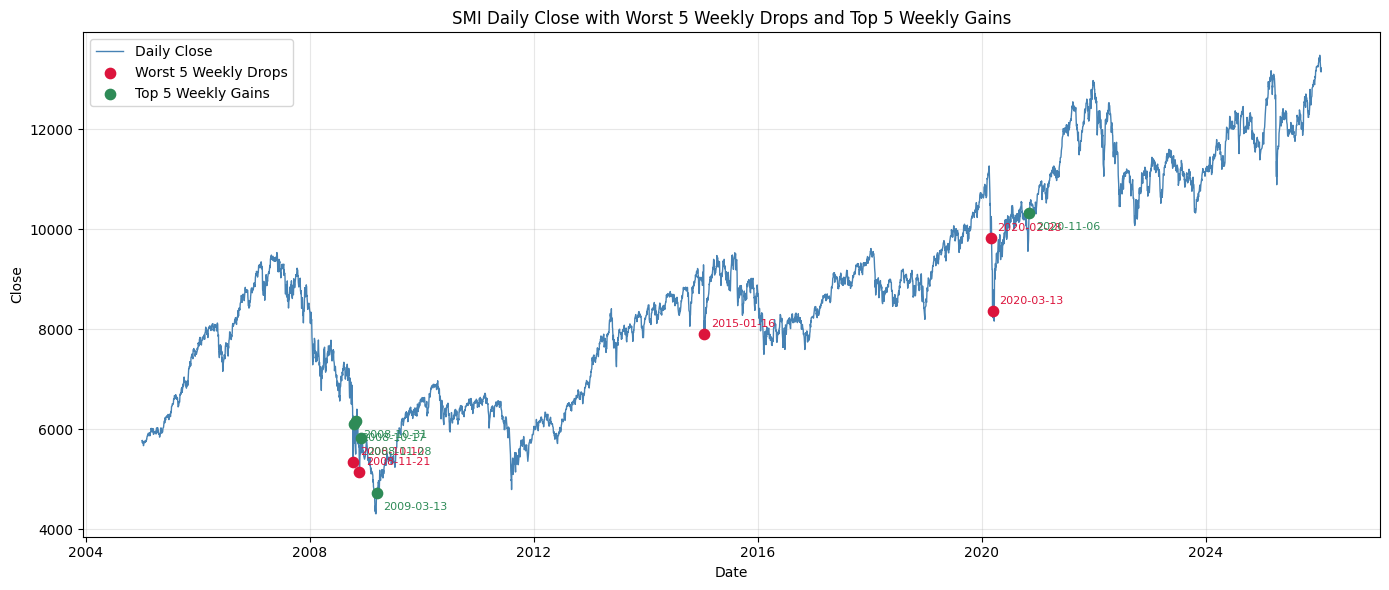

In [8]:
# Plot daily close with weekly drop markers
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=1, label='Daily Close')

# Mark worst weekly drops on the corresponding week-end date
worst_dates = worst_5.index
worst_values = df.set_index('Date').loc[worst_dates, 'Close']
plt.scatter(worst_dates, worst_values, color='crimson', s=55, zorder=3, label='Worst 5 Weekly Drops')

for d, v in zip(worst_dates, worst_values):
    plt.annotate(d.strftime('%Y-%m-%d'), (d, v), textcoords='offset points', xytext=(5, 5), fontsize=8, color='crimson')

# Mark best weekly gains on the corresponding week-end date
best_dates = best_5.index
best_values = df.set_index('Date').loc[best_dates, 'Close']
plt.scatter(best_dates, best_values, color='seagreen', s=55, zorder=3, label='Top 5 Weekly Gains')

for d, v in zip(best_dates, best_values):
    plt.annotate(d.strftime('%Y-%m-%d'), (d, v), textcoords='offset points', xytext=(5, -12), fontsize=8, color='seagreen')

plt.title('SMI Daily Close with Worst 5 Weekly Drops and Top 5 Weekly Gains')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# List worst and best weekly returns
worst_5_table = worst_5.to_frame(name='Weekly Return (%)')
worst_5_table.index.name = 'Week Ending (Fri)'
worst_5_table['Weekly Return (%)'] = (worst_5_table['Weekly Return (%)'] * 100).round(2)
print('Worst 5 Weekly Returns (%)')
display(worst_5_table)

best_5_table = best_5.to_frame(name='Weekly Return (%)')
best_5_table.index.name = 'Week Ending (Fri)'
best_5_table['Weekly Return (%)'] = (best_5_table['Weekly Return (%)'] * 100).round(2)
print('Top 5 Weekly Returns (%)')
display(best_5_table)


Worst 5 Weekly Returns (%)


,Weekly Return (%)
Week Ending (Fri),
2008-10-10,-22.28
2020-03-13,-14.06
2015-01-16,-13.25
2008-11-21,-11.84
2020-02-28,-11.52


Top 5 Weekly Returns (%)


,Weekly Return (%)
Week Ending (Fri),
2008-10-17,14.07
2008-11-28,13.07
2009-03-13,9.63
2008-10-31,8.42
2020-11-06,7.67


In [10]:
from IPython.display import HTML, display
from modules.bertopic_mpnet_topics import get_top_topic_docs_for_timerange
from modules.notebook_helpers import display_topic_timerange_results

def show_week_topics(weeks, label, border, bg_top, bg_bottom, text_main, text_sub):
    for week_end, ret in weeks.items():
        week_end = pd.to_datetime(week_end)
        week_start = week_end - pd.Timedelta(days=6)
        header_html = f"<div style='margin:16px 0 12px 0;padding:16px 18px;border:1px solid {border};border-radius:12px;background:linear-gradient(180deg,{bg_top},{bg_bottom});font-family:ui-sans-serif,system-ui,sans-serif;'><div style='font-size:2rem;line-height:1.2;font-weight:800;color:{text_main};'>{label}: Week {week_start.date()} to {week_end.date()}</div><div style='margin-top:6px;font-size:1.05rem;color:{text_sub};'>Return: <strong>{ret:.2%}</strong></div></div>"
        display(HTML(header_html))
        topic_docs = get_top_topic_docs_for_timerange(
            timerange_start=str(week_start.date()),
            timerange_end=str(week_end.date()),
            min_topic_count=5,
            min_probability=0.9,
            top_n_topics=3,
        )
        display_topic_timerange_results(topic_docs, max_content_chars=800)

show_week_topics(
    worst_5,
    label='Worst 5',
    border='#fca5a5',
    bg_top='#fff1f2',
    bg_bottom='#ffe4e6',
    text_main='#9f1239',
    text_sub='#be123c',
)

show_week_topics(
    best_5,
    label='Top 5',
    border='#86efac',
    bg_top='#f0fdf4',
    bg_bottom='#dcfce7',
    text_main='#14532d',
    text_sub='#166534',
)


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2008-10-04 to 2008-10-10 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2020-03-07 to 2020-03-13 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2015-01-10 to 2015-01-16 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2008-11-15 to 2008-11-21 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2020-02-22 to 2020-02-28 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2008-10-11 to 2008-10-17 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2008-11-22 to 2008-11-28 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2009-03-07 to 2009-03-13 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2008-10-25 to 2008-10-31 vs prior history:


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2020-10-31 to 2020-11-06 vs prior history:
